In [3]:
import matplotlib.pyplot as plt
import kwant
import numpy as np
import scipy
import scipy.ndimage
import scipy.linalg as la
%matplotlib inline

In [12]:
designfile = '/users/tkm/kanilmaz/thesis/designfiles/hb_lower_part.png'

In [13]:
topgate = 1 - scipy.ndimage.imread(designfile, mode='L').T / 255

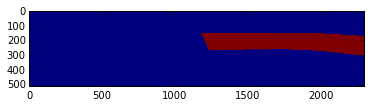

In [14]:
plt.imshow(topgate)

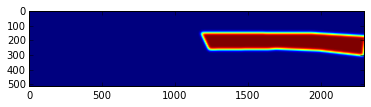

In [15]:
topgate_gauss = scipy.ndimage.gaussian_filter(topgate, 10)
plt.imshow(topgate_gauss)

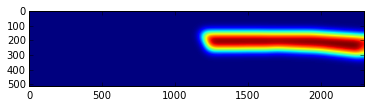

In [16]:
topgate_gauss = scipy.ndimage.gaussian_filter(topgate, 30)
plt.imshow(topgate_gauss)

In [10]:
dfile2 = '/users/tkm/kanilmaz/thesis/designfiles/halfBarrier.png'
tg2 = 1 - scipy.ndimage.imread(dfile2, mode='L').T / 255

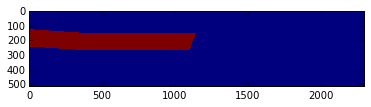

In [11]:
plt.imshow(tg2)

In [53]:
scattering_region = np.ones(topgate.shape)

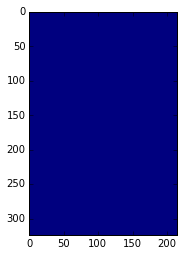

In [54]:
plt.imshow(scattering_region)

In [14]:
scattering_region.shape, topgate.shape

((215, 324), (215, 324))

In [55]:
delta = 1.0 
T = delta / 2
eta = 2.5 
gamma = 0.4
at = 5.0
a = 0.4

In [59]:
topgateGauss.shape, topgate.shape

((324, 215), (324, 215))

In [85]:
a*np.arange(topgateGauss.shape[0])

array([   0. ,    0.4,    0.8,    1.2,    1.6,    2. ,    2.4,    2.8,
          3.2,    3.6,    4. ,    4.4,    4.8,    5.2,    5.6,    6. ,
          6.4,    6.8,    7.2,    7.6,    8. ,    8.4,    8.8,    9.2,
          9.6,   10. ,   10.4,   10.8,   11.2,   11.6,   12. ,   12.4,
         12.8,   13.2,   13.6,   14. ,   14.4,   14.8,   15.2,   15.6,
         16. ,   16.4,   16.8,   17.2,   17.6,   18. ,   18.4,   18.8,
         19.2,   19.6,   20. ,   20.4,   20.8,   21.2,   21.6,   22. ,
         22.4,   22.8,   23.2,   23.6,   24. ,   24.4,   24.8,   25.2,
         25.6,   26. ,   26.4,   26.8,   27.2,   27.6,   28. ,   28.4,
         28.8,   29.2,   29.6,   30. ,   30.4,   30.8,   31.2,   31.6,
         32. ,   32.4,   32.8,   33.2,   33.6,   34. ,   34.4,   34.8,
         35.2,   35.6,   36. ,   36.4,   36.8,   37.2,   37.6,   38. ,
         38.4,   38.8,   39.2,   39.6,   40. ,   40.4,   40.8,   41.2,
         41.6,   42. ,   42.4,   42.8,   43.2,   43.6,   44. ,   44.4,
      

In [56]:
topgateGauss = scipy.ndimage.gaussian_filter(topgate, 20)

potential = scipy.interpolate.RectBivariateSpline(
    x=(a*np.arange(topgateGauss.shape[0])),
    y=(a*np.arange(topgateGauss.shape[1])),
    z=topgateGauss, 
    kx=1,
    ky=1,
)

bilayer =  kwant.lattice.general([(at*np.sqrt(3)/2, at*1/2), (0, at*1)],
                                 [(0, 0.0), (at*1 / (2*np.sqrt(3)), at*1/2), 
                                  (-at*1/(2*np.sqrt(3)), at*1/2), (0, 0)])
a1, b1, a2, b2 = bilayer.sublattices
hoppings1 = (((0, 0), a1, b1), ((0, 1), a1, b1), ((1, 0), a1, b1)) 
hoppings2 = (((0, 0), a2, b2), ((0, -1), a2, b2), ((1, -1), a2, b2))

In [57]:
def onsite(site, par):    
    topgate_potential = par.v_sg * potential(site.pos[0], site.pos[1]) 
    mu = (par.v_bg + topgate_potential) / 2 
    delta = - (topgate_potential - par.v_bg) / eta 
    # site.family in (a1, b1)
    if (site.family == a1 or site.family == b1):
        return - mu - delta 
    return -mu + delta

def onsite_lead(site, par):     
    topgate_potential = 0
    mu = (par.v_bg + topgate_potential) / 2
    delta = - ( topgate_potential - par.v_bg) / eta
    if site.family == a1 or site.family == b1:
        return - mu - delta
    return -mu  + delta

def geomShape(pos):
    #x, y = pos
    if pos[0] < 0 or pos[1] < 0:
        return False
    try:
        # rather round()?
        return scattering_region[int(pos[0] / a), int(pos[1] / a)]
    except IndexError:
        return False

def hop_intra_layer(site1, site2, par): 
    xt, yt = site1.pos 
    xs, ys = site2.pos
    return -par.t * np.exp(-0.5j * np.pi * par.B  * (xt - xs) * (yt + ys))

def hop_inter_layer(site1, site2, par): 
    return -par.gamma1 

def hop_intra_layer_lead(site1, site2, par): 
    return -par.t 

def hop_inter_layer_lead(site1, site2, par): 
    return -par.gamma1 

def leadShape1(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[0, int(y / a)]
    except IndexError:
        return False
    
def leadShape2(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[-1, int(y / a)]
    except IndexError:
        return False

def trs(m):
    return m.conj()

class TRIInfiniteSystem(kwant.builder.InfiniteSystem):
    def __init__(self, lead, trs):
        """A lead with time reversal invariant modes."""
        self.__dict__ = lead.__dict__
        self.trs = trs

    def modes(self, energy=0, args=()):
        prop_modes, stab_modes =             super(TRIInfiniteSystem, self).modes(energy=energy, args=args)
        n = stab_modes.nmodes
        stab_modes.vecs[:, n:(2*n)] = self.trs(stab_modes.vecs[:, :n])
        stab_modes.vecslmbdainv[:, n:(2*n)] =             self.trs(stab_modes.vecslmbdainv[:, :n])
        prop_modes.wave_functions[:, n:] =             self.trs(prop_modes.wave_functions[:, :n])
        return prop_modes, stab_modes

def make_system():
    system = kwant.Builder()
    scat_width = scattering_region.shape[0]
    scat_length = scattering_region.shape[1]

    system[bilayer.shape(geomShape, (0.5*a*scat_width, 0.5*a*scat_length))] = onsite 
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer
    system[kwant.builder.HoppingKind((0, 0), a1, b2) ] = hop_inter_layer    

    trans_sym_1 = kwant.TranslationalSymmetry(bilayer.vec((-2, 1)))
    lead_1 = kwant.Builder(trans_sym_1)
    lead_1[bilayer.shape(leadShape1, (0, 0.5*a*scat_length))] = onsite_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_1[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead

    trans_sym_2 = kwant.TranslationalSymmetry(bilayer.vec((2, -1))) #?
    lead_2 = kwant.Builder(trans_sym_2)
    lead_2[bilayer.shape(leadShape2, (0, 0.5*a*scat_length))] = onsite_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_2[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
     
    system.attach_lead(lead_1)
    system.attach_lead(lead_2)
    system = system.finalized()
    system.leads = [TRIInfiniteSystem(lead, trs) for lead in system.leads]
    
    return(system)

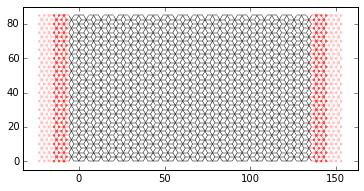

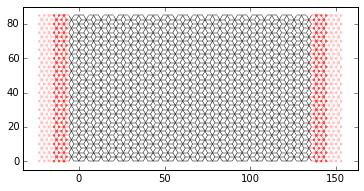

In [58]:
system = make_system()
kwant.plotter.plot(system)

In [70]:
scattering_region.shape

(324, 215)

In [90]:
for site in system.sites[:10]:
    print(site.family, site.tag)
    print(site.pos[0], site.pos[1])
    print(potential(site.pos[0], site.pos[1]))
    

<Monatomic lattice 1> [26 -13]
114.02667816495108 2.5
[[ 1.]]
<Monatomic lattice 0> [12 5]
51.96152422706631 55.0
[[ 0.78046604]]
<Monatomic lattice 3> [2 0]
8.660254037844386 5.0
[[ 0.99995586]]
<Monatomic lattice 2> [11 8]
46.18802153517006 70.0
[[ 0.99569922]]
<Monatomic lattice 2> [3 15]
11.547005383792513 85.0
[[ 1.]]
<Monatomic lattice 2> [27 -13]
115.47005383792514 5.0
[[ 0.99995586]]
<Monatomic lattice 1> [24 1]
105.3664241271067 67.5
[[ 0.98964593]]
<Monatomic lattice 0> [8 -3]
34.64101615137754 5.0
[[ 0.99995586]]
<Monatomic lattice 0> [11 2]
47.63139720814412 37.5
[[ 0.47176468]]
<Monatomic lattice 2> [1 5]
2.886751345948128 30.0
[[ 0.75893934]]


In [84]:
system.sites[0].tag

array([26, -13])